In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.environ["CUDA_VISIBLE_DEVICES"],torch.cuda.device_count(), torch.cuda.current_device())

0 1 0


In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch import optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

print(torch.__version__)
torch.cuda.is_available()

import h5py


1.12.0+cu102


## Data loading

In [3]:
file_list = glob.glob("/ssd/Protein_extracted_data/*.h5")
file_list.sort()
print(len(file_list))


new_list = []
for i in file_list:
    with h5py.File(i, "r") as f:
            # dist_ref = np.array(f.get('dist_ref'))
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            # mask = np.array(f.get('mask'))
            f.close()
    if len(sse.shape)!=0:
        if sse.shape[-1]!=0:
            new_list.append(i)
print(len(new_list))#,error_list)


c = 0
max_value = 0
min_value = 100000

for i in new_list:
    with h5py.File(i, "r") as f:
            dist_ref = np.expand_dims(np.array(f.get('dist_ref')),axis=0)
    if dist_ref.max()>max_value:
        max_value = dist_ref.max()
    if dist_ref.min()<min_value:
        min_value = dist_ref.min()
print(min_value,max_value)

9058
6109
0.0 309.6966314479636


In [4]:
#15051
file_list = new_list#glob.glob("/home/jupyter-jathurshan/Protein_extracted_data/*.h5")
# file_list.sort()
# print(len(file_list))

train_file_list = file_list[:int(len(file_list)*0.8)]
val_file_list = file_list[int(len(file_list)*0.8):int(len(file_list)*0.9)]
test_file_list = file_list[int(len(file_list)*0.9):]

print(len(train_file_list),len(val_file_list),len(test_file_list))

4887 611 611


In [5]:
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    # plt.show()
    return fig


## Disto ref

In [6]:
# import h5py
# ### Using Distant Ref
# class Protein_Dataset(Dataset):
#     def __init__(self,file_list, device,pro_len = 64):
      
#         self.file_list = file_list
#         self.pro_len = pro_len
#         self.device = device
        
#         self.device = device
        
#         print(f"Data_size : {len(self.file_list)}") 
        
#     def __len__(self):
#         return len(self.file_list )

#     def __getitem__(self, idx):
        
#         with h5py.File(self.file_list[idx], "r") as f:
#             dist_ref = np.array(f.get('dist_ref'))
#             dist_ref[np.isnan(dist_ref)] = 0
#             sse = np.array(f.get('sse'))
#             # seq = np.array(f.get('seq'))
#             mask = np.array(f.get('mask'))
#             f.close()
        
       
        
#         dist_ref = torch.from_numpy(dist_ref).unsqueeze(0).clamp(max=50)
#         dist_ref =dist_ref/50
#         sse = torch.from_numpy(sse).unsqueeze(0).float()
#         # seq = np.array(f.get('seq'))
#         mask = torch.from_numpy(mask).squeeze().unsqueeze(0)
#         ref_len = dist_ref.shape[-1]
#         # print(self.file_list[idx],dist_ref.shape,sse.shape)
        
#         # print(self.file_list[idx],dist_ref.shape,mask.shape,sse.shape)
        
# #         if dist_ref.shape[-1]<self.pro_len:
# #             pad = ((self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2)
# #             dist_ref =  F.pad(dist_ref, pad, mode='reflect')
# #             mask =  F.pad(mask, pad, mode='constant')
            
# #             pad = ((self.pro_len-sse.shape[-1])//2,(self.pro_len-sse.shape[-1])//2)
# #             sse =  F.pad(sse, pad, mode='reflect')
# #         elif dist_ref.shape[-1]>self.pro_len:
# #             crop = transforms.CenterCrop(self.pro_len)
# #             dist_ref = crop(dist_ref)
# #             mask = crop(mask)
# #             crop = transforms.CenterCrop((3,self.pro_len))
# #             sse = crop(sse)
         
#         if dist_ref.shape[-1]!=self.pro_len:
#             crop = transforms.CenterCrop(self.pro_len)
#             dist_ref = crop(dist_ref)
#             mask = crop(mask)
#             crop = transforms.CenterCrop((3,self.pro_len))
#             sse = crop(sse)
           
        
# #         
#         return dist_ref.to(self.device).float(), mask.to(self.device).float(), sse.to(self.device).float(),ref_len

## Disto binned

In [7]:
import h5py
### Using Distant binned
def mtx2bins(x_ref, start, end, nbins, mask):
    bins = np.linspace(start, end, nbins)
    x_true = np.digitize(x_ref, bins).astype(np.uint8)
    x_true[mask] = 0
    return np.eye(nbins+1)[x_true][...,:-1]
class Protein_Dataset(Dataset):
    def __init__(self,file_list, device,pro_len = 64):
      
        self.file_list = file_list
        self.pro_len = pro_len
        self.device = device
        
        self.device = device
        
        print(f"Data_size : {len(self.file_list)}") 
        
    def __len__(self):
        return len(self.file_list )

    def __getitem__(self, idx):
        
        with h5py.File(self.file_list[idx], "r") as f:
            # print(f.keys())
            dist_ref = np.array(f.get('dist_ref'))
            dist_ref[np.isnan(dist_ref)] = 0
            
            omega_ref = np.array(f.get('omega_ref'))
            # omega_ref[np.isnan(omega_ref)] = 0
            
            phi_ref = np.array(f.get('phi_ref'))
            # phi_ref[np.isnan(phi_ref)] = 0
            
            theta_ref = np.array(f.get('theta_ref'))
            # theta_ref[np.isnan(theta_ref)] = 0
            
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            mask = np.array(f.get('mask'))
            f.close()
        
       
        
        # dist_ref = torch.from_numpy(dist_ref).unsqueeze(0)#.clamp(max=50)
        # dist_ref =dist_ref/50
        dist_ref  = mtx2bins(dist_ref,2.0,  20.0, 37, mask=(dist_ref > 20))#),-1,0)
        omega_ref  = torch.moveaxis(torch.from_numpy(mtx2bins(omega_ref, -np.pi, np.pi, 25, mask=(dist_ref[...,0]==1))),-1,0)
        theta_ref  = torch.moveaxis(torch.from_numpy(mtx2bins(theta_ref, -np.pi, np.pi, 25, mask=(dist_ref[...,0]==1))),-1,0)
        phi_ref  = torch.moveaxis(torch.from_numpy(mtx2bins(phi_ref,0.0, np.pi, 13, mask=(dist_ref[...,0]==1))),-1,0)
        
        dist_ref = torch.moveaxis(torch.from_numpy(dist_ref),-1,0)
        
        # print(dist_ref.shape)
        sse = torch.from_numpy(sse).unsqueeze(0).float()
        # seq = np.array(f.get('seq'))
        mask = torch.from_numpy(mask).squeeze().unsqueeze(0)
        ref_len = dist_ref.shape[-1]
    
         
        if dist_ref.shape[-1]!=self.pro_len:
            crop = transforms.CenterCrop(self.pro_len)
            dist_ref = crop(dist_ref)
            omega_ref = crop(omega_ref)
            theta_ref = crop(theta_ref)
            phi_ref = crop(phi_ref)
            mask = crop(mask)
            crop = transforms.CenterCrop((3,self.pro_len))
            sse = crop(sse)
           
        
#         
        return [dist_ref.to(self.device).float(),omega_ref.to(self.device).float(),theta_ref.to(self.device).float(),phi_ref.to(self.device).float()], mask.to(self.device).float(), sse.to(self.device).float(),ref_len

In [8]:
train_dataset = Protein_Dataset(train_file_list, device = device) 
val_dataset = Protein_Dataset(val_file_list, device = device)

Data_size : 4887
Data_size : 611


In [9]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([32, 37, 64, 64]) torch.Size([32, 25, 64, 64]) torch.Size([32, 25, 64, 64]) torch.Size([32, 13, 64, 64]) torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 3, 64]) tensor([780, 285, 373, 195, 246,  56, 292,  95, 181, 436,  81, 120, 132, 391,
        126,  90, 122, 171, 158, 250, 117, 377, 561, 156, 141, 267, 477, 386,
        658,  56, 120, 254])



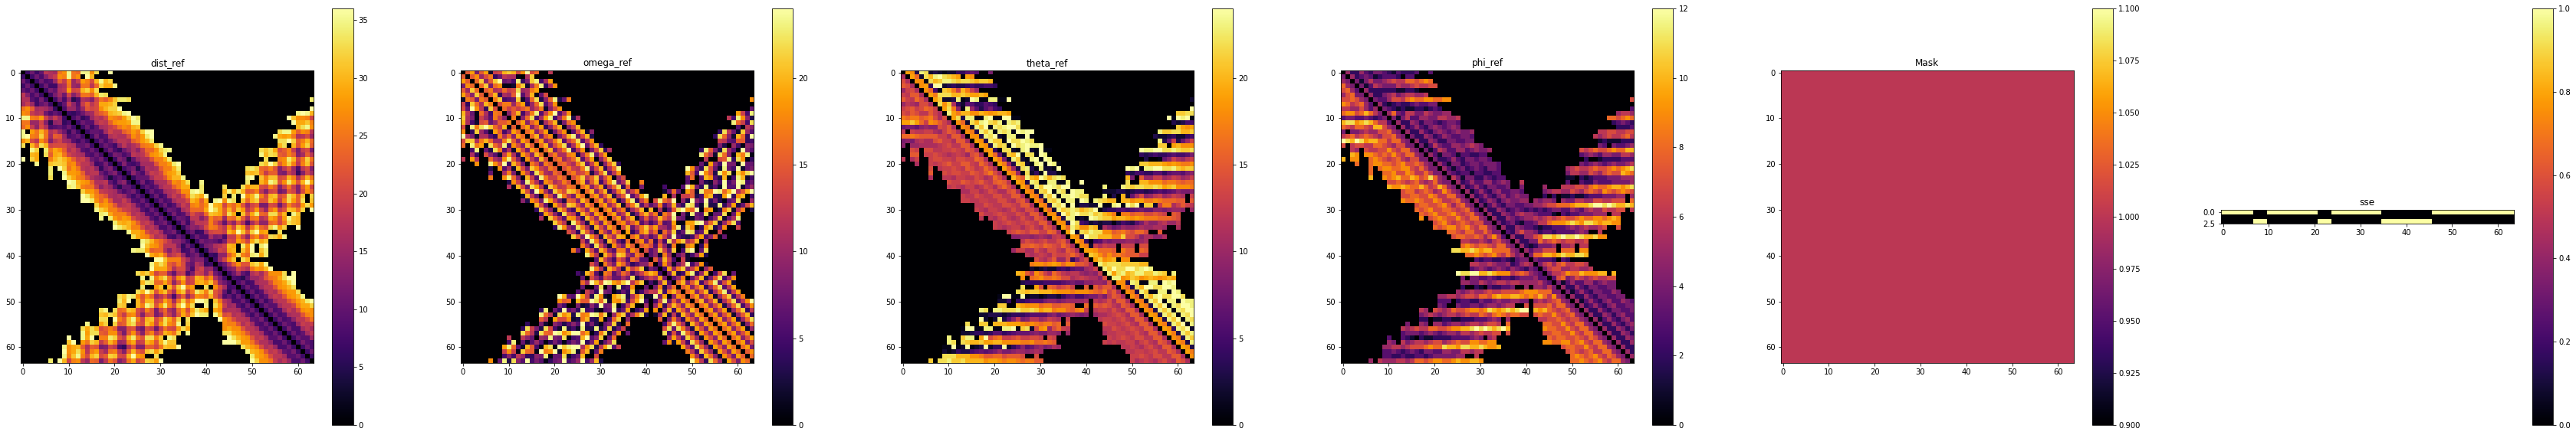

In [10]:
[dist_ref,omega_ref,theta_ref,phi_ref],mask,sse,ref_len   = next(iter(train_data_loader))

print(dist_ref.shape,omega_ref.shape,theta_ref.shape,phi_ref.shape,mask.shape,sse.shape,ref_len) 
ind = 0
img_list = [dist_ref[ind].argmax(0).squeeze().detach().cpu().numpy(),
            omega_ref[ind].argmax(0).squeeze().detach().cpu().numpy(),
            theta_ref[ind].argmax(0).squeeze().detach().cpu().numpy(),
            phi_ref[ind].argmax(0).squeeze().detach().cpu().numpy(),
           mask[ind].squeeze().detach().cpu().numpy(),
           sse[ind].squeeze().detach().cpu().numpy(),
           ]

title_list = ['dist_ref','omega_ref','theta_ref','phi_ref','Mask','sse']
plot_sub_plots(1,6,img_list,title_list,cmap = 'inferno')
print('')

## Model

In [11]:
class CNN_Encoder(nn.Module):
    
    def __init__(self, input_nc=1, ngf = 16):
        super(CNN_Encoder, self).__init__()
        self.enc1 = self.enc_block(in_ch = input_nc, out_ch = ngf, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc2 = self.enc_block(in_ch = ngf, out_ch = ngf*2, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc3 = self.enc_block(in_ch = ngf*2, out_ch = ngf*4, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc4 = self.enc_block(in_ch = ngf*4, out_ch = ngf*8, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc5 = self.enc_block(in_ch = ngf*8, out_ch = ngf*16, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        
        
    def enc_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size,stride=stride, padding=padding, bias=bias),
                # nn.ReLU()
                )
      
            
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        # x = self.enc3(x)
        # x = self.enc4(x)
        # x = self.enc5(x)
        return x
    

class CNN_Decoder(nn.Module):
    
    def __init__(self, lat_chan=128,out_ch = 1, ngf = 16 ):
        super(CNN_Decoder, self).__init__()
        self.dec1 = self.conv_up_block(in_ch = lat_chan , out_ch = ngf*8, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        self.dec2 = self.conv_up_block(in_ch = ngf*8 , out_ch = out_ch, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec3 = self.conv_up_block(in_ch = ngf*4 , out_ch = ngf*2, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec4 = self.conv_up_block(in_ch = ngf*2 , out_ch = 1, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec5 = self.conv_up_block(in_ch = ngf , out_ch = 1, 
                                       # kernel_size=4, stride=2, padding = 1,bias = True)
        # self.final = nn.Linear(16,out_ch)
        
        
    def conv_up_block(self,  in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True,outermost = False):
            return nn.Sequential(
                nn.ConvTranspose2d( in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding = padding,bias = bias),
                # nn.ReLU()
                )
        
    def forward(self,x): 
        x = self.dec1(x)
        
        x = self.dec2(x)
        
        
#         x = self.dec3(x)
        
#         x = self.dec4(x)
        # x = self.dec5(x)
        # x = self.final(x)
        # x = torch.moveaxis(x,-1,1)
        return x

In [12]:
class Multi_CNN_Encoder(nn.Module):
    
    def __init__(self, input_nc=1, ngf = 16):
        super(Multi_CNN_Encoder, self).__init__()
        self.dist_enc = CNN_Encoder(input_nc = 37,ngf = 16)#.to(device)
        self.omega_enc = CNN_Encoder(input_nc = 25,ngf = 16)#.to(device)
        self.theta_enc = CNN_Encoder(input_nc = 25,ngf = 16)#.to(device)
        self.phi_enc = CNN_Encoder(input_nc = 13,ngf = 16)#.to(device)
        
    def forward(self,x):
        dist_1 = self.dist_enc(x[0])
        omega_1 = self.omega_enc(x[1])
        theta_1 = self.theta_enc(x[2])
        phi_1 = self.phi_enc(x[3])
        
        lat_c = dist_1+omega_1+theta_1+phi_1
        return lat_c
    
    
class Multi_CNN_Decoder(nn.Module):
    
    def __init__(self, lat_chan=32):
        super(Multi_CNN_Decoder, self).__init__()
        self.dist_dec = CNN_Decoder(lat_chan=32,out_ch=37)#.to(device)
        self.omega_dec = CNN_Decoder(lat_chan=32,out_ch=25)
        self.theta_dec = CNN_Decoder(lat_chan=32,out_ch=25)
        self.phi_dec =CNN_Decoder(lat_chan=32,out_ch=13)
        
    def forward(self,x):
        dist_1 = self.dist_dec(x)
        omega_1 = self.omega_dec(x)
        theta_1 = self.theta_dec(x)
        phi_1 = self.phi_dec(x)
        

        return [dist_1,omega_1,theta_1,phi_1]

In [13]:
x,mask,sse,ref_len   = next(iter(train_data_loader))

encoder = Multi_CNN_Encoder(input_nc = 37,ngf = 16).to(device)
# decoder = Multi_CNN_Decoder(lat_chan=32).to(device)

lat_c = encoder(x)
# out = decoder(lat_c)
print(lat_c.shape)
# for i in x:
#     print(i.shape)
    
# for i in out:
    # print(i.shape)
#,out.shape)

torch.Size([32, 32, 16, 16])


## Structure Module

In [14]:
from Structure_Module.Structure_Module import StructureModule

ModuleNotFoundError: No module named 'attn_core_inplace_cuda'

In [14]:
criterion = nn.CrossEntropyLoss()
lr  = 0.001   
beta_1 = 0.9
beta_2 = 0.999
n_epochs = 500 
opt =  torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, betas=(beta_1, beta_2))

NameError: name 'decoder' is not defined

In [13]:
is_wandb = False
if is_wandb:
    import wandb
    wandb.init(project="diff_protein_gen", entity="jathurshan_0330")
    wandb.run.name = "Autoencoder Training Using All Binned Distograms+Angles (Only ones without Masks)"
    wandb.run.save()
    # "Finetuning only classification head Ki67 using SIMCLR Pretrained Model"
    exp_path = f"./model_checkpoints/{wandb.run.name}"
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)

In [20]:
def recon_loss(x_hat,x):
    criterion = nn.L1Loss()
    return criterion(x_hat,x)

def recon_loss_binned(x_hat,x):
    criterion = nn.CrossEntropyLoss()
    return criterion(x_hat,x)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

In [21]:
def train(encoder,decoder,opt,data_loader,is_wandb=False,verbose_freq = 500,is_verbose = False):
    encoder.train()
    decoder.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    train_losses = AverageMeter()
    end = time.time()
    
    for batch_idx, (x,m,_,_ ) in enumerate(data_loader): 
        data_time.update(time.time() - end)
        
        opt.zero_grad()
        c_hat = encoder(x)
        x_hat = decoder(c_hat)
        # print((x.argmax(1).unsqueeze(1)*m).shape)
        loss = recon_loss_binned(x_hat[0]*m,(x[0].argmax(1).unsqueeze(1)*m).squeeze().type(torch.cuda.LongTensor))
        loss += recon_loss_binned(x_hat[1]*m,(x[1].argmax(1).unsqueeze(1)*m).squeeze().type(torch.cuda.LongTensor))
        loss += recon_loss_binned(x_hat[2]*m,(x[2].argmax(1).unsqueeze(1)*m).squeeze().type(torch.cuda.LongTensor))
        loss += recon_loss_binned(x_hat[3]*m,(x[3].argmax(1).unsqueeze(1)*m).squeeze().type(torch.cuda.LongTensor))
        
        
        loss.backward()
        opt.step()
        
        train_losses.update(loss.data.item())
        batch_time.update(time.time() - end)
        end = time.time()
        
        if is_verbose:
            if (batch_idx+1) % verbose_freq == 0:
                msg = 'Epoch: [{0}/{3}][{1}/{2}]\t' \
                      'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t' \
                      'Speed {speed:.1f} samples/s\t' \
                      'Data {data_time.val:.3f}s ({data_time.avg:.3f}s)\t' \
                      'Loss {train_loss.val:.5f} ({train_loss.avg:.5f})\t'.format(
                          epoch_idx+1, batch_idx,len(data_loader), n_epochs , batch_time=batch_time,
                          speed=x.size(0)/batch_time.val,
                          data_time=data_time, train_loss=train_losses)
                print(msg)
        
        if is_wandb:
            wandb.log({"batch_loss": loss.data.item()})
    
    
    if is_wandb:
            wandb.log({"train_epoch_loss": train_losses.avg})
            wandb.log({"training time/Iter": batch_time.sum/len(data_loader)})
    
    
    # print(f"Evaluation   Epoch : {epoch_idx+1}  =====================>")
    if is_verbose:
        print(f"Training Epoch Loss: {train_losses.avg}")
    return train_losses.avg
        
        
def validate(encoder,decoder,data_loader,is_wandb=False,is_verbose = False):
    encoder.eval()
    decoder.eval()
    
    val_losses = AverageMeter()
    
    
    with torch.no_grad():
        for batch_idx, (x,m,_,_ ) in enumerate(data_loader): 
            c_hat = encoder(x)
            x_hat = decoder(c_hat)

            loss = recon_loss_binned(x_hat[0]*m,(x[0].argmax(1).unsqueeze(1)*m).squeeze().type(torch.cuda.LongTensor))
            loss += recon_loss_binned(x_hat[1]*m,(x[1].argmax(1).unsqueeze(1)*m).squeeze().type(torch.cuda.LongTensor))
            loss += recon_loss_binned(x_hat[2]*m,(x[2].argmax(1).unsqueeze(1)*m).squeeze().type(torch.cuda.LongTensor))
            loss += recon_loss_binned(x_hat[3]*m,(x[3].argmax(1).unsqueeze(1)*m).squeeze().type(torch.cuda.LongTensor))
        
            val_losses.update(loss.data.item())
            
            
    x,mask,sse,ref_len   = next(iter(data_loader))
    with torch.no_grad():
        c_hat = encoder(x)
        x_hat = decoder(c_hat)
    # print(dist_ref.shape,mask.shape,sse.shape,ref_len) 
    # ind = 0
    img_list = [x[0][1].argmax(0).squeeze().detach().cpu().numpy(),
                x[1][1].argmax(0).squeeze().detach().cpu().numpy(),
                x[2][1].argmax(0).squeeze().detach().cpu().numpy(),
                x[3][1].argmax(0).squeeze().detach().cpu().numpy(),
                x_hat[0][1].argmax(0).squeeze().detach().cpu().numpy(),
                x_hat[1][1].argmax(0).squeeze().detach().cpu().numpy(),
                x_hat[2][1].argmax(0).squeeze().detach().cpu().numpy(),
                x_hat[3][1].argmax(0).squeeze().detach().cpu().numpy(),
                x[0][2].argmax(0).squeeze().detach().cpu().numpy(),
                x[1][2].argmax(0).squeeze().detach().cpu().numpy(),
                x[2][2].argmax(0).squeeze().detach().cpu().numpy(),
                x[3][2].argmax(0).squeeze().detach().cpu().numpy(),
                x_hat[0][2].argmax(0).squeeze().detach().cpu().numpy(),
                x_hat[1][2].argmax(0).squeeze().detach().cpu().numpy(),
                x_hat[2][2].argmax(0).squeeze().detach().cpu().numpy(),
                x_hat[3][2].argmax(0).squeeze().detach().cpu().numpy(),
                ]
                
    title_list = ['dist_ref','omega_ref','theta_ref','phi_ref',
                  'Pred_dist','Pred_omega','Pred_theta','Pred_phi',
                  'dist_ref','omega_ref','theta_ref','phi_ref',
                  'Pred_dist','Pred_omega','Pred_theta','Pred_phi']
    fig = plot_sub_plots(4,4,img_list,title_list,cmap = 'inferno')
    if is_wandb:
            wandb.log({"examples": wandb.Image(fig)})
            
    if is_wandb:
            wandb.log({"val_epoch_loss": val_losses.avg})
    
    
    # print(f"Evaluation   Epoch : {epoch_idx+1}  =====================>")
    if is_verbose:
        print(f"Val Epoch Loss: {val_losses.avg}")
    return val_losses.avg

In [22]:
# exp_path = "./model_checkpoints/autoencoder_MNIST/"
# if not os.path.exists(exp_path):
#     os.mkdir(exp_path)

In [ ]:
val_best_loss = 10000000
train_loss_list = []
val_loss_list = []

# if not os.path.exists(exp_path):
#     os.mkdir(exp_path)
print("Training ", end='')
for epoch_idx in range(n_epochs):
    print('=', end='')
    # print(f"Training Epoch : [{epoch_idx+1}/{n_epochs}]===============================================================================")
    
    train_loss = train(encoder,decoder,opt,train_data_loader,is_wandb=is_wandb)    
    val_losses = validate(encoder,decoder,val_data_loader,is_wandb=is_wandb) 

    train_loss_list.append(train_loss)
    val_loss_list.append(val_losses)
    if (val_losses < val_best_loss): 
        val_best_loss = val_losses
        # print("Saving Best Model =======================================>")
        torch.save(encoder, f'{exp_path}/encoder_dist.pth.tar')
        torch.save(decoder, f'{exp_path}/decoder_dist.pth.tar')
    
    
plt.figure()
plt.plot(train_loss_list)
plt.title("Train Loss")

plt.figure()
plt.plot(val_loss_list)
plt.title("Val Loss")

Training =====================

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


## Latent Space Visualization

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
enc_path = f'{exp_path}/encoder_2.pth.tar'
encoder = torch.load(enc_path).to(device)
encoder.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

In [ ]:
dec_path = f'{exp_path}/decoder_2.pth.tar'
decoder = torch.load(dec_path).to(device)
decoder.eval()
print(sum([np.prod(p.size()) for p in decoder.parameters()]))

In [ ]:
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    plt.show()
    # return fig

for batch_idx, (x,label) in enumerate(val_data_loader): 
    c_hat = encoder(x.to(device))
    x_hat = decoder(c_hat)
    break
    
    
plot_sub_plots(1,2,[x[2].detach().squeeze().cpu().numpy(),x_hat[2].detach().squeeze().cpu().numpy()],['GT','Gen'])

In [ ]:
for batch_idx, (x,label) in enumerate(val_data_loader): 
    c_hat = encoder(x.to(device))
    if batch_idx==0:
        features = c_hat
        label_list = label
    else:
        features = torch.cat((features,c_hat),axis = 0)
        label_list = torch.cat((label_list,label),axis = 0)
print(features.shape,label_list.shape)

features = features.flatten(start_dim = 1).detach().cpu().numpy()
label_list = label_list.detach().cpu().numpy()

In [ ]:
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(features)

In [ ]:
plt.figure(figsize = (20,20))
plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=label_list, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing MNIST latent space through t-SNE', fontsize=24);